# Example of Training a NN on ILThermo Data

Start by importing some modules:

In [6]:
import pandas as pd
import salty
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [431]:
class dev_model():
    """
    the dev_model is the properly formated object to be passed to machine
    learning engine. The input features are all scaled and centered, the data
    summary describes the distribution of the data (in terms of state variables
    and output values).
    """
    def __init__(self, coef_data, data_summary, data):
        self.coef = coef_data
        self.summary = data_summary
        self.data = data

In [435]:
import statistics
import time
from os.path import dirname, join
import pandas as pd
import sys
import dill
from math import inf
from math import log
from math import exp
from sklearn.preprocessing import Imputer
import numpy as np
from sklearn.preprocessing import StandardScaler

def aggregate_data(df, target, T=[0, inf], P=[0, inf], data_ranges=None,
                   merge="overlap", feature_type=None, impute=False,
                   scale_center=True):
    """
    Aggregates molecular data for model training

    Parameters
    ----------
    data: list
        density, cpt, and/or viscosity
    T: array
        desired min and max of temperature distribution
    P: array
        desired min and max of pressure distribution
    data_ranges: array
        desired min and max of property distribution(s)
    merge: str
        overlap or union, defaults to overlap. Merge type of property sets
    feature_type: str
        desired feature set, defaults to RDKit's 2D descriptor set

    Returns
    -----------
    devmodel: dev_model obj
        returns dev_model object containing scale/center information,
        data summary, and the data frame
    """
    merged = df
    target_and_states = target + ['Temperature, K', 'Pressure, kPa']

    if merge == "overlap":
        merged.dropna(inplace=True)
    # select state variable and data ranges
    merged = merged.loc[merged["Temperature, K"] < T[1]]
    merged = merged.loc[merged["Temperature, K"] > T[0]]
    merged = merged.loc[merged["Pressure, kPa"] < P[1]]
    merged = merged.loc[merged["Pressure, kPa"] > P[0]]
    for index, item in enumerate(target):
        if data_ranges:
            merged = merged[merged[item] < data_ranges[index][1]]
            merged = merged[merged[item] > data_ranges[index][0]]
    merged.reset_index(drop=True, inplace=True)

    # Create summary of dataset
    unique_mixtures = merged.groupby(["smiles-cation", "smiles-anion", "smiles-solvent", "mol fraction salt"]).count().shape[0]
    unique_systems = merged.groupby(["smiles-cation", "smiles-anion", "smiles-solvent"]).count().shape[0]
    unique_cations = repr(merged["smiles-cation"].unique())
    unique_anions = repr(merged["smiles-anion"].unique())
    unique_solvents = repr(merged["smiles-solvent"].unique())
    actual_data_ranges = []
    for index, item in enumerate(target_and_states):
        actual_data_ranges.append("{} - {}".format(
            str(merged[item].min()), str(merged[item].max())))
    summary = np.array([unique_mixtures, unique_systems, unique_cations, unique_anions, unique_solvents,
                 merged.shape[0]])
    summary = np.concatenate((summary, actual_data_ranges))

    cols1 = ["Unique mixtures", "Unique Systems", "Cations", "Anions", "Solvents", "Total datapoints"]
    cols = cols1 + target_and_states
    data_summary = pd.DataFrame(summary, cols)

    # scale and center
    metaDf = merged.select_dtypes(include=["object"])
    dataDf = merged.select_dtypes(include=[np.number])
    cols = dataDf.columns.tolist()
    if impute:
        imp = Imputer(missing_values='NaN', strategy="median", axis=0)
        X = imp.fit_transform(dataDf)
        dataDf = pd.DataFrame(X, columns=cols)
    instance = StandardScaler()
    if scale_center:
        for i in range(1, len(data) + 1):
            dataDf.is_copy = False
            dataDf.iloc[:, -i] = dataDf.iloc[:, -i].apply(lambda x:
                                                          log(float(x)))
        scaled_data = pd.DataFrame(instance.
                                   fit_transform(dataDf.iloc[:, :-len(data)]),
                                   columns=cols[:-len(data)])
        df = pd.concat([scaled_data, dataDf.iloc[:, -len(data):], metaDf],
                       axis=1)
        mean_std_of_coeffs = pd.DataFrame([instance.mean_, instance.scale_],
                                          columns=cols[:-len(data)])
    else:
        instance.fit(dataDf.iloc[:, :-len(data)])
        df = pd.concat([dataDf, metaDf], axis=1)
        mean_std_of_coeffs = pd.DataFrame([instance.mean_, instance.scale_],
                                          columns=cols[:-len(data)])
    devmodel = dev_model(mean_std_of_coeffs, data_summary, df)
    return devmodel

In [510]:
df = pd.read_csv('../development/mixture_heat_capacity_premodel.csv')
target = ['Heat capacity at constant pressure, J/K/mol']
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 103] # we will set MD simulation to 101 kPa and 298 K
data_range = [[0, 2295]] #the cpt dataset has one outlier ~9,000 J/mol/K
devmodel = aggregate_data(df, target, T=T, P=P, data_ranges=data_range)
X_train, Y_train, X_test, Y_test = devmodel_to_array\
    (devmodel, train_fraction=0.8)
devmodel.summary
print("Total training data: {}".format(X_train.shape[0]))
print("Total testing data: {}".format(X_test.shape[0]))

Total training data: 1618
Total testing data: 405


In [500]:
def devmodel_to_array(model_name, train_fraction=1):
    """
    a standardized method of turning a dev_model object into training and
    testing arrays

    Parameters
    ----------
    model_name: dev_model
        the dev_model object to be interrogated
    train_fraction: int
        the fraction to be reserved for training

    Returns
    ----------
    X_train: array
        the input training array
    X_test: array
        the input testing array
    Y_train: array
        the output training array
    Y_test: array
        the output testing array
    """
    model_outputs = -8 + model_name.summary.shape[0]
    devmodel = model_name
    rawdf = devmodel.data
    rawdf = rawdf.sample(frac=1)
    datadf = rawdf.select_dtypes(include=[np.number])

    data = np.array(datadf)

    n = data.shape[0]
    d = data.shape[1]
    d -= model_outputs
    n_train = int(n * train_fraction)  # set fraction for training
    n_test = n - n_train

    X_train = np.zeros((n_train, d))  # prepare train/test arrays
    X_test = np.zeros((n_test, d))
    Y_train = np.zeros((n_train, model_outputs))
    Y_test = np.zeros((n_test, model_outputs))
    X_train[:] = data[:n_train, :-model_outputs]
    Y_train[:] = (data[:n_train, -model_outputs:].astype(float))
    X_test[:] = data[n_train:, :-model_outputs]
    Y_test[:] = (data[n_train:, -model_outputs:].astype(float))
    return X_train, Y_train, X_test, Y_test

In [477]:
def merge_duplicates(devmodel, target, keep_descriptors=False):
    """
    Identifies repeated experimental values and returns mean values for those
    data along with their standard deviation. Only aggregates experimental
    values that have been acquired at the same temperature and pressure.

    Parameters
    ----------
    model_name: dev_model
        the dev_model object to be interrogated
    keep_descriptors: boolean, default False
        if True descriptors will be included in the output DataFrame

    Returns
    -----------
    out: dataframe
        pandas DataFrame of the original data where repeated measurements
        have been averaged and their variance stored in a separate column
    """
    model_outputs = len(target)
    cols = devmodel.data.columns
    for index, item in enumerate(target):
        devmodel.data[item] = \
            devmodel.data[item].apply(
            lambda x: exp(float(x)))
    output_val = pd.DataFrame()
    output_xtd = pd.DataFrame()
    for index, item in enumerate(target):
        val = devmodel.data.groupby(["smiles-cation", "smiles-anion", "smiles-solvent", "mol fraction salt"]
                                    )[item].mean().\
            reset_index()
        xtd = devmodel.data.groupby(["smiles-cation", "smiles-anion", "smiles-solvent", "mol fraction salt"]
                                    )[item].std().\
            reset_index()
        if index == 0:
            output_val = val
            output_xtd = xtd
        else:
            output_val = pd.merge(output_val, val)
            output_xtd = pd.merge(output_xtd, xtd)
    size = devmodel.data.groupby(["smiles-cation", "smiles-anion", "smiles-solvent", "mol fraction salt"]
                                    )[item].count().\
        reset_index()
    cations = devmodel.data.groupby(["smiles-cation", "smiles-anion", "smiles-solvent", "mol fraction salt"]
                                    )['name-cation'].first().reset_index()
    anions = devmodel.data.groupby(["smiles-cation", "smiles-anion", "smiles-solvent", "mol fraction salt"]
                                   )['name-anion'].first().reset_index()
    solvents = devmodel.data.groupby(["smiles-cation", "smiles-anion", "smiles-solvent", "mol fraction salt"]
                                   )['name-solvent'].first().reset_index()

    size.columns.values[-1] = "count"

    unique_mixtures = devmodel.data.groupby(["smiles-cation", "smiles-anion", "smiles-solvent", "mol fraction salt"]).count().shape[0]
    unique_systems = devmodel.data.groupby(["smiles-cation", "smiles-anion", "smiles-solvent"]).count().shape[0]

    print("Identified {} unique mixtures in {} datapoints".
      format(unique_mixtures, devmodel.data.shape[0]))

    out = pd.merge(output_val, output_xtd,
                   on=["smiles-cation", "smiles-anion", "smiles-solvent", "mol fraction salt"],
                   suffixes=['_mean', '_std'])
    out = pd.merge(out, size)
    out = pd.merge(out, cations)
    out = pd.merge(out, anions)
    out = pd.merge(out, solvents)
    if keep_descriptors:
        from rdkit import Chem
        from rdkit.ML.Descriptors.MoleculeDescriptors import\
            MolecularDescriptorCalculator as calculator

        solvent_di = {'water': 'O',
                      'urea': 'NC(N)=O',
                      'ethanol': 'OCC',
                      'methanol': 'OC',
                      'glycerol': 'C(C(CO)O)O',
                      '1,2-ethanediol': 'C(CO)O',
                      'propan-1-ol': 'CCCO',
                      'octan-1-ol': 'CCCCCCCCO',
                      'acetonitrile': 'CC#N',
                      'nitromethane': 'C[N+](=O)[O-]',
                      'N-methylaniline': 'CNC1=CC=CC=C1',
                      '2-methylaniline': 'CC1=CC=CC=C1N',
                      'aniline': 'C1=CC=C(C=C1)N',
                      'cyclopentanone': 'C1CCC(=O)C1',
                      'cyclohexanone': 'C1CCC(=O)CC1',
                      'pyridine': 'C1=CC=NC=C1',
                      '2-pyrrolidinone': 'C1CC(=O)NC1',
                      'N-methylpyrrolidone': 'CN1CCCC1=O',
                      'bromobenzene': 'C1=CC=C(C=C1)Br',
                      'butan-1-ol': 'CCCCO',
                      'propan-2-ol': 'CC(C)O'
                     }

        old = pd.DataFrame()
        deslist = salty.load_data("cationDescriptors.csv").columns[2:]
        for index, item in enumerate(solvent_di):
            mol = Chem.MolFromSmiles(solvent_di[item])
            feature_vector = [item, solvent_di[item]]
            for desc in deslist:
                feature_vector.append(calculator([desc]).CalcDescriptors(mol)[0])
            new = pd.DataFrame(feature_vector).T
            new.columns = [str(i) + '-solvent' for i in salty.load_data("cationDescriptors.csv").columns]
            new = pd.concat([new, old], axis=0, sort=False)
            old = new
        solventDescriptors = old

        cationDescriptors = salty.load_data("cationDescriptors.csv")
        cationDescriptors.columns = [str(col) + '-cation' for
                                     col in cationDescriptors.columns]
        anionDescriptors = salty.load_data("anionDescriptors.csv")
        anionDescriptors.columns = [str(col) + '-anion' for
                                    col in anionDescriptors.columns]
        new_df = pd.merge(cationDescriptors, out,
                          on=["name-cation", "smiles-cation"], how="right")
        new_df = pd.merge(anionDescriptors, new_df,
                          on=["name-anion", "smiles-anion"], how="right")
        new_df = pd.merge(solventDescriptors, new_df, on="name-solvent", how="right")
        new_df.dropna(inplace=True) #remove entries not in smiles database
        out = new_df
    return out

In [491]:
devmodel = aggregate_data(df, target, T=T, P=P, data_ranges=data_range)
merged = merge_duplicates(devmodel, target)

Identified 643 unique mixtures in 2023 datapoints


In [492]:
merged.dropna(inplace = True)
merged = merged.loc[merged['count'] >= 3]
print("IL systems with three or more datapoints: {}".format(merged.shape[0]))
print("average relative std: {:.1f}".format(np.mean(merged['Heat capacity at constant pressure, J/K/mol_std']/
                                         merged['Heat capacity at constant pressure, J/K/mol_mean']*100)))

IL systems with three or more datapoints: 528
average relative std: 1.3


Our models were trained with keras, using a tensor flow backend. 

In [502]:
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping

early = EarlyStopping(monitor='mean_squared_error', patience=50, verbose=1)
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=['mse'])
model.fit(X_train,Y_train,epochs=10000,verbose=False,callbacks=[early])
test_scores = model.evaluate(X_test, Y_test) 
train_scores = model.evaluate(X_train, Y_train)
print("%s: %.2f%% for train data" % (model.metrics_names[1], train_scores[1]*100))
print("%s: %.2f%% for test set" % (model.metrics_names[1], test_scores[1]*100))

Epoch 00450: early stopping
1618/1618 [==============================] - 0s 41us/step
mean_squared_error: 0.27% for train data
mean_squared_error: 0.30% for test set


In [503]:
def coeff_determination(y_true, y_pred):
    yhat = y_pred
    y = y_true
    ybar = np.sum(y)/len(y)  
    ssreg = np.sum((yhat-ybar)**2)  
    sstot = np.sum((y - ybar)**2)   
    ssres = np.sum((y-yhat)**2)
    results = 1 - (ssres / sstot)
    return results

In [504]:
print('R square for test data: {:.2f}'.format(coeff_determination(np.exp(Y_test), np.exp(model.predict(X_test)))))
print('R square for train data: {:.2f}'.format(coeff_determination(np.exp(Y_train), np.exp(model.predict(X_train)))))

R square for test data: 0.99
R square for train data: 0.99


In [505]:
def raad(y_true, y_pred):
    return np.sum(np.abs((y_pred-y_true)/y_true))/len(y_true)*100

In [506]:
print('RAAD for test data: {:.2f}'.format(raad(np.exp(Y_test), np.exp(model.predict(X_test)))))
print('RAAD for train data: {:.2f}'.format(raad(np.exp(Y_train), np.exp(model.predict(X_train)))))

RAAD for test data: 3.68
RAAD for train data: 3.54


In [507]:
def rmse(y_true, y_pred):
    return np.sqrt(np.sum((y_pred-y_true)**2)/len(y_true))

In [508]:
print('RMSE for test data: {:.2f}'.format(rmse(np.exp(Y_test), np.exp(model.predict(X_test)))))
print('RMSE for train data: {:.2f}'.format(rmse(np.exp(Y_train), np.exp(model.predict(X_train)))))

RMSE for test data: 10.92
RMSE for train data: 10.07


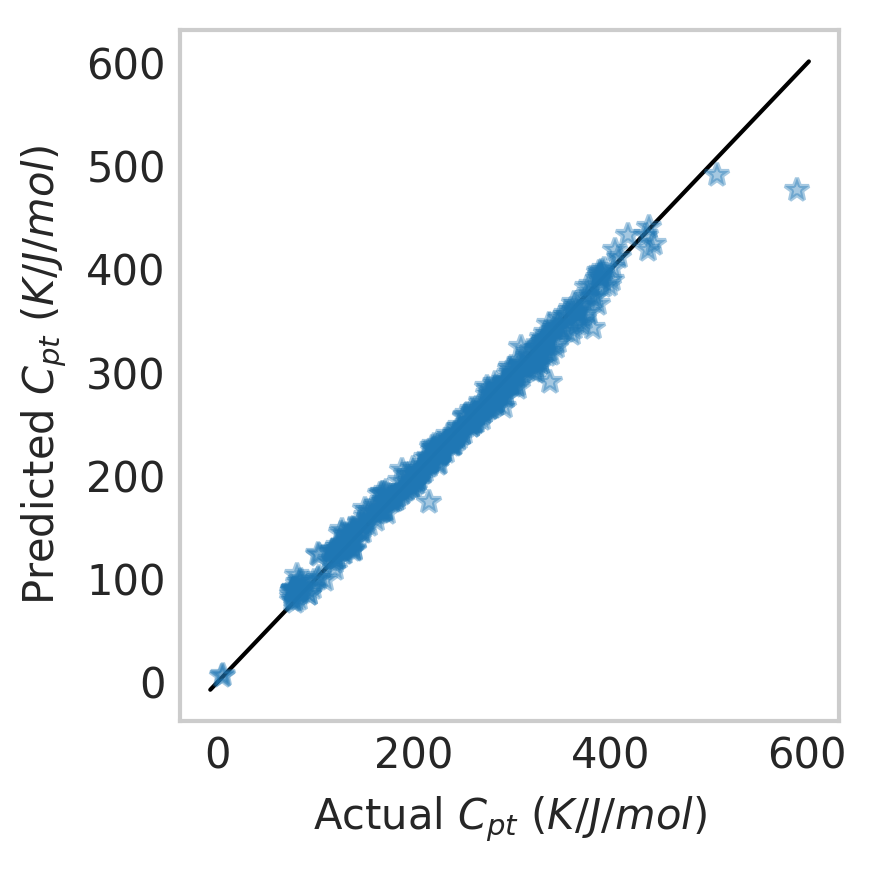

In [509]:
X=X_test
Y=Y_test
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(3,3), dpi=300)
    ax=fig.add_subplot(111)
    minval = np.min([np.exp(model.predict(X)[:]), np.exp(Y)[:]])
    maxval = np.max([np.exp(model.predict(X)[:]), np.exp(Y)[:]])
    buffer = (maxval - minval) / 100 * 2
    minval = minval - buffer
    maxval = maxval + buffer
    ax.plot([minval, maxval], [minval, maxval], linestyle="-",
            label=None, c="black", linewidth=1)
    ax.plot(np.exp(Y)[:],np.exp(model.predict(X))[:],\
            marker="*",linestyle="",alpha=0.4)
    ax.set_ylabel("Predicted $C_{pt}$ $(K/J/mol)$")
    ax.set_xlabel("Actual $C_{pt}$ $(K/J/mol)$")
    ax.grid()
    plt.tight_layout()

## Density

In [511]:
df = pd.read_csv('../development/mixture_density_premodel.csv')

In [518]:
target = [df.columns[-2]]
print(target)

['Specific density, kg/m<SUP>3</SUP>']


In [523]:
T = [297, 316] # select state variable ranges according to manuscript
P = [99, 102] # we will set MD simulation to 101 kPa and 298 K
data_range = [[0, 10095]] #the cpt dataset has one outlier ~9,000 J/mol/K
devmodel = aggregate_data(df, target, T=T, P=P, data_ranges=data_range)
X_train, Y_train, X_test, Y_test = devmodel_to_array\
    (devmodel, train_fraction=0.8)
print("Total training data: {}".format(X_train.shape[0]))
print("Total testing data: {}".format(X_test.shape[0]))
devmodel.summary

Total training data: 25824
Total testing data: 6457


,0
Unique mixtures,8546
Unique Systems,446
Cations,"array(['CCCCCCCCn1cc[n+](c1)C', 'CCCCCCn1cc[n+..."
Anions,"array(['[B-](F)(F)(F)F', 'F[P-](F)(F)(F)(F)F',..."
Solvents,"array(['CC(C)O', 'CCCCO', 'CN1CCCC1=O', 'C1CC(..."
Total datapoints,32281
"Specific density, kg/m<SUP>3</SUP>",550.0 - 1546.6
"Temperature, K",269.1 - 473.15
"Pressure, kPa",96.7 - 40120.0


In [526]:
merged = merge_duplicates(devmodel, target)

Identified 8545 unique mixtures in 32281 datapoints


In [527]:
merged.dropna(inplace = True)
print("IL systems with three or more datapoints: {}".format(merged.shape[0]))
print("average % std: {:.2f}".format(np.mean(merged['Specific density, kg/m<SUP>3</SUP>_std']/
                                         merged['Specific density, kg/m<SUP>3</SUP>_mean']*100)))

IL systems with three or more datapoints: 5722
average % std: 5.83


In [ ]:
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping

early = EarlyStopping(monitor='mean_squared_error', patience=50, verbose=1)
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=['mse'])
model.fit(X_train,Y_train,epochs=10000,verbose=False,callbacks=[early])
test_scores = model.evaluate(X_test, Y_test) 
train_scores = model.evaluate(X_train, Y_train)
print("%s: %.2f%% for train data" % (model.metrics_names[1], train_scores[1]*100))
print("%s: %.2f%% for test set" % (model.metrics_names[1], test_scores[1]*100))

In [ ]:
print('R square for test data: {:.2f}'.format(coeff_determination(np.exp(Y_test), np.exp(model.predict(X_test)))))
print('R square for train data: {:.2f}'.format(coeff_determination(np.exp(Y_train), np.exp(model.predict(X_train)))))

In [ ]:
print('RAAD for test data: {:.2f}'.format(raad(np.exp(Y_test), np.exp(model.predict(X_test)))))
print('RAAD for train data: {:.2f}'.format(raad(np.exp(Y_train), np.exp(model.predict(X_train)))))

In [ ]:
print('RMSE for test data: {:.2f}'.format(rmse(np.exp(Y_test), np.exp(model.predict(X_test)))))
print('RMSE for train data: {:.2f}'.format(rmse(np.exp(Y_train), np.exp(model.predict(X_train)))))

In [ ]:
# to load models as fitness criteria for the GAINS module
# they can be saved like so:
def save_model(name, model, devmodel, path=None):
    if path:
        model.save("{}{}_qspr.h5".format(path, name))
        devmodel.Data_summary.to_csv("{}{}_summ.csv".format(path, name))
        devmodel.Coef_data.to_csv("{}{}_desc.csv".format(path, name), index=False)
    else:
        model.save("{}_qspr.h5".format(name))
        devmodel.Data_summary.to_csv("{}_summ.csv".format(name))
        devmodel.Coef_data.to_csv("{}_desc.csv".format(name), index=False)